# UNet сегментация

## Kaggle датасет

In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import models

from skimage import data

from PIL import Image

from tqdm import trange, tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset_path = "/kaggle/input/productsdefects-nodefects-01-03-25/productsDefects-noDefects-01-03-25"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")

dataset_path_test = "/kaggle/input/good-dataset-0-1/good_dataset_0_1"
test_images_path = os.path.join(dataset_path_test, "images/test")
test_masks_path = os.path.join(dataset_path_test, "annotations/test")

print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

print("\nПримеры файлов (Train Images):", os.listdir(train_images_path)[:5])
print("Примеры файлов (Train Masks):", os.listdir(train_masks_path)[:5])

Train Images: 3517
Train Masks: 3517
Test Images: 277
Test Masks: 277

Примеры файлов (Train Images): ['0006_0084_JPG.rf.a3863aa00c3f3abbdb14840e826ae441.jpg', '023_png.rf.d0418b0479a2cd539d98aa7b59b1a19f.jpg', 'fresh_strawberry_171_jpg.rf.1c96734018e9fff2ed86ff3ac0caf580.jpg', 'fresh_strawberry_122_jpg.rf.38f83af72e476ea9d0df55eb1fc01c37.jpg', '148_png.rf.563e9c619d7ec9a578fa674e4e51c55c.jpg']
Примеры файлов (Train Masks): ['00480_jpg.rf.ca82249251908e5ab9b5a21e03ac234c.png', '00166_jpg.rf.8fc92688a825a3d4c9d5298c39c5dde1.png', '0008_0014_JPG.rf.1261e130dc9e2252f111752c27e04fbb.png', 'fresh_strawberry_42_jpg.rf.74a81dbf7ac29071798085fe9a2d7ed1.png', '0002_0180_JPG.rf.1671037bf3f4003417ea45a5e4b3291f.png']


✅ Изображение: (234, 326, 3), Маска: (234, 326), dtype: uint8


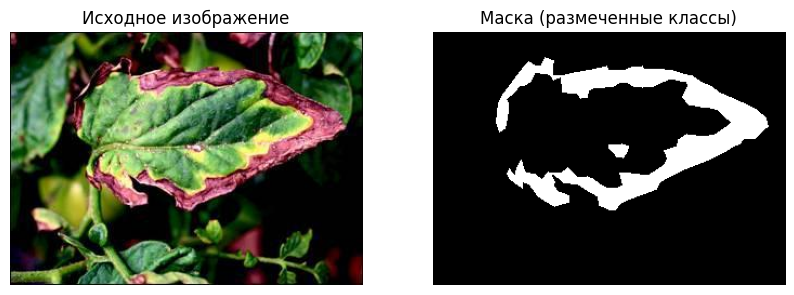

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Функция для загрузки и отображения изображения и маски
def visualize_sample(image_path, mask_path):
    # Проверяем существование файлов
    if not os.path.exists(image_path):
        print(f"❌ Изображение не найдено: {image_path}")
        return
    if not os.path.exists(mask_path):
        print(f"❌ Маска не найдена: {mask_path}")
        return
    
    # Загружаем изображение
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB

    mask = Image.open(mask_path).convert("L")  # Преобразуем в оттенки серого
    mask = np.array(mask)

    print(f"✅ Изображение: {image.shape}, Маска: {mask.shape}, dtype: {mask.dtype}")

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Исходное изображение")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Маска (размеченные классы)")
    ax[1].axis("off")

    plt.show()

image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

sample_image = image_files[0]  # Берем первое изображение

sample_mask = os.path.splitext(sample_image)[0] + ".png"

# Полные пути
image_path = os.path.join(train_images_path, sample_image)
mask_path = os.path.join(train_masks_path, sample_mask)

visualize_sample(image_path, mask_path)


In [4]:
mask_files = sorted(os.listdir(train_masks_path))

all_classes = set()

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    unique_classes = np.unique(mask_array)
    all_classes.update(unique_classes)

print(f"Общее количество уникальных классов: {len(all_classes)}")
print(f"Уникальные классы: {sorted(all_classes)}")

Общее количество уникальных классов: 2
Уникальные классы: [0, 1]


## PyTorch датасет и даталоадер

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class PlantSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        mask_filename = os.path.splitext(image_filename)[0] + ".png"
        image_path = os.path.join(self.images_dir, image_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))  # Ресайз до 512x512
        image = image.astype(np.float32) / 255.0  # Нормализация [0,1]

        # Конвертируем изображение в три канала (копируем одно и то же изображение в 3 канала)
        image = np.stack([image, image, image], axis=-1)  # [H, W, 3]

        # Загружаем маску (градации серого)
        mask = Image.open(mask_path).convert("L")  # Преобразуем в оттенки серого
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)  # Ресайз маски (NEAREST для классов)
        mask = np.array(mask, dtype=np.int64)  # Оставляем как int64 (классы)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Преобразуем в тензоры
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

train_dataset = PlantSegDataset(train_images_path, train_masks_path, img_size=512)

sample_img, sample_mask = train_dataset[0]
print(f"Форма изображения: {sample_img.shape}")  # [3, 512, 512]
print(f"Форма маски: {sample_mask.shape}")        # [512, 512]
print(f"Классы в маске: {torch.unique(sample_mask)}")


Форма изображения: torch.Size([3, 512, 512])
Форма маски: torch.Size([512, 512])
Классы в маске: tensor([0, 1])


## Classic U-net
U-Net: Convolutional Networks for Biomedical Image Segmentation


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="800"/>


Перейдем к самой сети U-net - в ней не просто принимаем на вход изображение, сжимаем его, а потом разжимаем, но при это еще делим глобальные skip connection'ы (серые стрелки). Важно, чтобы все работало, чтобы выход слоя (начало стрелка) должен совпадать с входом слоя (остриё стрелки), поэтому надо соблюдать такую совместимость.

Посмотрим, какой размер идет на вход и какой получается на выходе. В нашем примере на вход 3 (канала) и размерность изображения (384, 512), а на выходе хотим маску, у которой будет 1 канал, а при этом этот 1 канал будет отвечать за 1 класс (в нашем случае датасет состоит из 1 класса - человек). Если было бы несколько классов, то на выходе было бы несколько каналов и выдавались, например, двухканальное бинарное изображение, где первый канал отвечал за человека, а второй за кота.

Implementation

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [6]:
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

batch_images, batch_masks = next(iter(train_loader))
print(f"Размер batch изображений: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"Размер batch масок: {batch_masks.shape}")        # [B, 512, 512]

Размер batch изображений: torch.Size([8, 3, 512, 512])
Размер batch масок: torch.Size([8, 512, 512])


In [7]:
import torchvision.models.segmentation as segmentation
deeplab = segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.backbone

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 220MB/s] 


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [8]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

# Загружаем backbone из DeepLabV3+
backbone = deeplabv3_resnet50(pretrained=True).backbone

# Тестовый входной тензор (имитируем изображение 512x512 с 3 каналами)
x = torch.randn(1, 3, 512, 512)

# Проход по слоям и вывод их размеров
s1 = backbone.conv1(x)  # После первого сверточного слоя
s1 = backbone.bn1(s1)  # После BatchNorm
s1 = backbone.relu(s1)  # После ReLU
s1 = backbone.maxpool(s1)  # После MaxPool
print(f"s1 (после maxpool): {s1.shape}")  # Ожидаем (1, 64, 128, 128)

s2 = backbone.layer1(s1)
print(f"s2: {s2.shape}")  # Ожидаем (1, 256, 128, 128)

s3 = backbone.layer2(s2)
print(f"s3: {s3.shape}")  # Ожидаем (1, 512, 64, 64)

s4 = backbone.layer3(s3)
print(f"s4: {s4.shape}")  # Ожидаем (1, 1024, 32, 32)

bottleneck = backbone.layer4(s4)
print(f"bottleneck: {bottleneck.shape}")  # Ожидаем (1, 2048, 16, 16)


s1 (после maxpool): torch.Size([1, 64, 128, 128])
s2: torch.Size([1, 256, 128, 128])
s3: torch.Size([1, 512, 64, 64])
s4: torch.Size([1, 1024, 64, 64])
bottleneck: torch.Size([1, 2048, 64, 64])


In [9]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Адаптер для приведения skip к нужному числу каналов
        self.skip_conv = nn.Conv2d(skip_channels, out_channels, kernel_size=1)
        
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)  
        
        skip = self.skip_conv(skip)  # Преобразуем skip-карту
        x = torch.cat([x, skip], dim=1)  
        x = self.conv(x)
        return x

class UNetWithDeepLabEncoder(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = deeplabv3_resnet50(pretrained=True).backbone
        
        # Извлекаем слои энкодера (последовательные уровни ResNet)
        self.enc1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.encoder.maxpool)
        self.enc2 = self.encoder.layer1  # 256
        self.enc3 = self.encoder.layer2  # 512
        self.enc4 = self.encoder.layer3  # 1024
        self.enc5 = self.encoder.layer4  # 2048 (bottleneck)
        
        # Декодер с использованием skip connections
        self.dec4 = UNetDecoderBlock(2048, 512, 1024)
        self.dec3 = UNetDecoderBlock(512, 256, 512)
        self.dec2 = UNetDecoderBlock(256, 128, 256)
        self.dec1 = UNetDecoderBlock(128, 64, 64)   # 128 -> 64
        
        # Финальный слой для сегментации
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Энкодер (из DeepLabV3+)
        s1 = self.enc1(x)  # 64, 128x128
        s2 = self.enc2(s1)  # 256, 128x128
        s3 = self.enc3(s2)  # 512, 64x64
        s4 = self.enc4(s3)  # 1024, 64x64
        bottleneck = self.enc5(s4)  # 2048, 64x64
        
        # Декодер с skip connections
        d4 = self.dec4(bottleneck, s4)  # 512, 64x64
        d3 = self.dec3(d4, s3)  # 256, 64x64
        d2 = self.dec2(d3, s2)  # 128, 128x128
        d1 = self.dec1(d2, s1)  # 64, 128x128
        
        # Выходное изображение
        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)  #до 512x512
        return out

if __name__ == "__main__":
    model = UNetWithDeepLabEncoder(num_classes=1)
    x = torch.randn(1, 3, 512, 512)
    y = model(x)
    print(f"Output shape: {y.shape}")  #(1, 1, 512, 512)


Output shape: torch.Size([1, 1, 512, 512])


In [10]:
unet = UNetWithDeepLabEncoder(num_classes=1)
x = torch.randn(1, 3, 1024, 1024)
out = unet(x)
print(out.shape)

torch.Size([1, 1, 1024, 1024])


In [11]:
# Замораживаем backbone (энкодер)
for name, param in model.encoder.named_parameters():
    param.requires_grad = True
    print(f"Разморожено: {name}")

# Размораживаем декодер (по частям)
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        param.requires_grad = True
        print(f"Разморожено: {name}")

print("\nПроверка:")
print("Backbone layers (должно быть True):")
for name, param in model.encoder.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

print("\nDecoder layers (должно быть True):")
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")



Разморожено: conv1.weight
Разморожено: bn1.weight
Разморожено: bn1.bias
Разморожено: layer1.0.conv1.weight
Разморожено: layer1.0.bn1.weight
Разморожено: layer1.0.bn1.bias
Разморожено: layer1.0.conv2.weight
Разморожено: layer1.0.bn2.weight
Разморожено: layer1.0.bn2.bias
Разморожено: layer1.0.conv3.weight
Разморожено: layer1.0.bn3.weight
Разморожено: layer1.0.bn3.bias
Разморожено: layer1.0.downsample.0.weight
Разморожено: layer1.0.downsample.1.weight
Разморожено: layer1.0.downsample.1.bias
Разморожено: layer1.1.conv1.weight
Разморожено: layer1.1.bn1.weight
Разморожено: layer1.1.bn1.bias
Разморожено: layer1.1.conv2.weight
Разморожено: layer1.1.bn2.weight
Разморожено: layer1.1.bn2.bias
Разморожено: layer1.1.conv3.weight
Разморожено: layer1.1.bn3.weight
Разморожено: layer1.1.bn3.bias
Разморожено: layer1.2.conv1.weight
Разморожено: layer1.2.bn1.weight
Разморожено: layer1.2.bn1.bias
Разморожено: layer1.2.conv2.weight
Разморожено: layer1.2.bn2.weight
Разморожено: layer1.2.bn2.bias
Разморожено:

### Обучение

[Epoch 1/10, Step 1/439] Loss: 0.7351, IoU: 0.0142, Accuracy: 0.0142
[Epoch 1/10, Step 11/439] Loss: 0.6352, IoU: 0.0000, Accuracy: 0.9546
[Epoch 1/10, Step 21/439] Loss: 0.0753, IoU: 0.0000, Accuracy: 0.9837
[Epoch 1/10, Step 31/439] Loss: 0.0967, IoU: 0.0000, Accuracy: 0.9950
[Epoch 1/10, Step 41/439] Loss: 0.3096, IoU: 0.0000, Accuracy: 0.8856
[Epoch 1/10, Step 51/439] Loss: 0.1541, IoU: 0.0000, Accuracy: 0.9477
[Epoch 1/10, Step 61/439] Loss: 0.1757, IoU: 0.0000, Accuracy: 0.9419
[Epoch 1/10, Step 71/439] Loss: 0.0513, IoU: 0.0000, Accuracy: 0.9923
[Epoch 1/10, Step 81/439] Loss: 0.0669, IoU: 0.0000, Accuracy: 0.9827
[Epoch 1/10, Step 91/439] Loss: 0.0277, IoU: 0.0000, Accuracy: 0.9991
[Epoch 1/10, Step 101/439] Loss: 0.0509, IoU: 0.0000, Accuracy: 0.9958
[Epoch 1/10, Step 111/439] Loss: 0.0620, IoU: 0.0000, Accuracy: 0.9815
[Epoch 1/10, Step 121/439] Loss: 0.0339, IoU: 0.0000, Accuracy: 0.9972
[Epoch 1/10, Step 131/439] Loss: 0.1294, IoU: 0.0000, Accuracy: 0.9632
[Epoch 1/10, Step

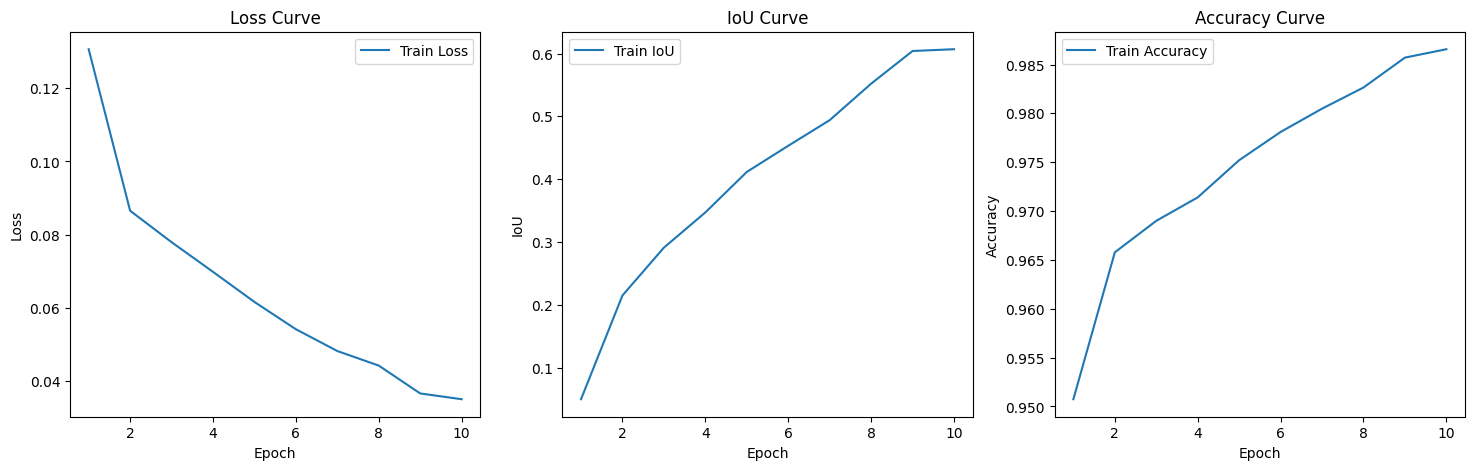

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()  # Бинаризуем предсказания
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / union if union > 0 else torch.tensor(1.0)
    return iou.item()

def calculate_accuracy(pred, target):
    pred = (pred > 0.5).float()  # Бинаризуем предсказания
    correct = (pred == target).sum()
    total = target.numel()
    accuracy = correct / total
    return accuracy.item()

def train_model(model, train_loader, num_epochs=10, lr=0.001, device="cuda"):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Используем BCE с логитами
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_ious, train_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_iou, epoch_accuracy = 0, 0, 0

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device).unsqueeze(1).float()  # Добавляем канал и приводим к float
        
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            iou = calculate_iou(outputs.sigmoid(), masks)
            accuracy = calculate_accuracy(outputs.sigmoid(), masks)

            epoch_loss += loss.item()
            epoch_iou += iou
            epoch_accuracy += accuracy

            if i % 10 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}] Loss: {loss.item():.4f}, IoU: {iou:.4f}, Accuracy: {accuracy:.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        train_ious.append(epoch_iou / len(train_loader))
        train_accuracies.append(epoch_accuracy / len(train_loader))

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train IoU={train_ious[-1]:.4f}, Train Accuracy={train_accuracies[-1]:.4f}")

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs+1), train_ious, label="Train IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("IoU Curve")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

    torch.save(model.state_dict(), "u-net-good-dataset01-defects-nodefects.pth")

num_epochs = 10
learning_rate = 1e-4

train_model(model, train_loader, num_epochs=num_epochs, lr=learning_rate, device="cuda")


In [13]:
#torch.save(model.state_dict(), "u-net-mineralscreative15k.pth")

In [14]:
#device='cuda'
#model.load_state_dict(torch.load("/kaggle/working/u-net-mineralscreative15k.pth"))
#model.to(device)
#model.eval()

In [33]:
#dataset_path_test = "/kaggle/input/productsdefects-nodefects-01-03-25/productsDefects-noDefects-01-03-25"
#test_images_path = os.path.join(dataset_path_test, "images/test")
#test_masks_path = os.path.join(dataset_path_test, "annotations/test")


In [34]:
test_dataset = PlantSegDataset(test_images_path, test_masks_path, img_size=512)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=True)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)

        preds = (outputs.sigmoid() > 0.5).float()

        predictions.extend(preds.cpu().numpy())

print(f"Получены предсказания для {len(predictions)} изображений.")



In [ ]:
import random
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """Накладывает маску на изображение с прозрачностью."""
    colored_mask = np.zeros_like(image)
    for i in range(3):  
        colored_mask[:, :, i] = mask * color[i]
    
    return cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)

def visualize_predictions(test_loader, predictions, num_samples=10):
    """Визуализирует предсказания модели с наложением масок."""
    samples = random.sample(range(len(predictions)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    
    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        mask = mask.numpy()
        pred_mask = predictions[idx].squeeze(0)  # Исправление! (1, H, W) -> (H, W)

        image_vis = (image * 255).astype(np.uint8)

        overlay_pred = apply_mask(image_vis, pred_mask, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask(image_vis, mask, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image_vis)
        axes[i, 0].set_title("Original Image")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Mask Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Mask Overlay")
        
        axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.7)
        axes[i, 3].set_title("Predicted Mask")
        
        for ax in axes[i]:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_loader, predictions, num_samples=10)


In [ ]:
import numpy as np
import torch

def calculate_iou(preds, labels, num_classes):
    iou_per_class = []
    for i in range(num_classes):
        intersection = ((preds == i) & (labels == i)).sum().item()
        union = ((preds == i) | (labels == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_per_class.append(iou)
        
    return np.nanmean(iou_per_class)

def calculate_accuracy(preds, labels, threshold=0.5):
    """
    Рассчитывает точность (Accuracy) как процент правильно предсказанных пикселей.
    """
    # Убираем лишний канал в предсказаниях
    preds = preds.squeeze(1)
    
    preds = (preds > threshold).long()
    labels = (labels > threshold).long()

    correct = (preds == labels).sum().item()
    total = labels.numel()  # Общее количество пикселей в маске

    return correct / total if total > 0 else 0.0




test_ious = []
test_accuracies = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)  # Преобразуем логиты в вероятности
        preds = (probs > 0.5).long()  # Бинаризуем по порогу 0.5

        masks = (masks > 0.5).long()

        # IoU
        iou_batch = calculate_iou(preds, masks, num_classes=1)
        test_ious.append(iou_batch)

        # Accuracy
        acc = calculate_accuracy(preds, masks)
        test_accuracies.append(acc)

mean_iou = np.nanmean(test_ious)
mean_accuracy = np.mean(test_accuracies)

print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")
print(f"Средняя Accuracy на тестовой выборке: {mean_accuracy:.4f}")


In [ ]:
import numpy as np
import torch

def dice_score(preds, masks, num_classes):
    """
    Функция для расчета Dice Score для всех классов.
    """
    preds = preds.squeeze(1)
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    dice_per_class = np.zeros(num_classes)

    for i in range(num_classes):
        intersection = np.logical_and(preds == i, masks == i).sum()
        union = (preds == i).sum() + (masks == i).sum()

        if union > 0:
            dice_per_class[i] = (2 * intersection) / union
    
    mean_dice = np.mean(dice_per_class[dice_per_class > 0]) if np.any(dice_per_class > 0) else 0.0
    return dice_per_class, mean_dice


test_dices = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        _, mean_dice = dice_score(preds, masks, num_classes=2)
        test_dices.append(mean_dice)

mean_dice_score = np.mean(test_dices)

print(f"Средний Dice Score на тестовой выборке: {mean_dice_score:.4f}")

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_map(preds, masks):
    """
    Функция для вычисления mAP для бинарной сегментации (1 класс).
    """
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    y_true = (masks == 1).astype(np.uint8).flatten()
    y_pred = (preds == 1).astype(np.uint8).flatten()

    if np.sum(y_true) == 0:
        return 0.0

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ap = auc(recall, precision)

    return ap

test_map_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        mean_ap = calculate_map(preds, masks)
        test_map_scores.append(mean_ap)

mean_map = np.mean(test_map_scores)

print(f"Средний mAP на тестовой выборке: {mean_map:.4f}")


In [ ]:
def calculate_image_confusion_matrix(preds, masks):
    """
    Вычисляет Confusion Matrix (TP, FP, TN, FN) на уровне изображений.
    - TP (True Positive): модель правильно предсказала хотя бы 1 пиксель класса 1
    - FP (False Positive): модель предсказала класс 1, но в маске только 0
    - TN (True Negative): модель предсказала только 0, и в маске тоже только 0
    - FN (False Negative): модель предсказала только 0, но в маске есть 1
    """
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    batch_size = preds.shape[0]

    TP, FP, TN, FN = 0, 0, 0, 0

    for i in range(batch_size):
        y_pred = preds[i]
        y_true = masks[i]

        pred_has_1 = np.any(y_pred == 1)
        true_has_1 = np.any(y_true == 1)

        if pred_has_1 and true_has_1:
            TP += 1
        elif pred_has_1 and not true_has_1:
            FP += 1
        elif not pred_has_1 and not true_has_1:
            TN += 1
        elif not pred_has_1 and true_has_1:
            FN += 1

    return TP, FP, TN, FN

total_TP, total_FP, total_TN, total_FN = 0, 0, 0, 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        TP, FP, TN, FN = calculate_image_confusion_matrix(preds, masks)

        total_TP += TP
        total_FP += FP
        total_TN += TN
        total_FN += FN

print(f"True Positives (TP): {total_TP}")
print(f"False Positives (FP): {total_FP}")
print(f"True Negatives (TN): {total_TN}")
print(f"False Negatives (FN): {total_FN}")
